## **Policy Gradient Methods for Policy Search**

# **Monte Carlo Policy Gradient for Blackjack**

We solve the **Blackjack** environment using the **Monte Carlo Policy Gradient** algorithm. The Blackjack problem is a classic reinforcement learning (RL) problem where the agent learns to maximize its total rewards by deciding whether to "hit" (draw another card) or "stick" (stop drawing cards) to achieve a total as close to 21 as possible without exceeding it. The goal is to beat the dealer while avoiding going bust.

---

## **Policy Gradient Method**
The Policy Gradient algorithm is a Monte Carlo policy gradient method. In this approach, the policy is parameterized by a neural network with weights \( \theta \), which outputs a probability distribution over actions given the state \( s_t \). The objective is to maximize the expected return:

\[
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T G_t \right]
\]

where \( \tau \) represents a trajectory (sequence of states, actions, and rewards). The gradient of the objective function can be computed as:

\[
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) G_t \right]
\]

This equation guides us to adjust the policy parameters in the direction of increasing the log-probability of actions that lead to higher returns.

---

## **Neural Network Policy**
A neural network is used to approximate the policy \( \pi_\theta(a|s) \). The network consists of an input layer, one hidden layer, and an output layer. The output layer applies the softmax function to generate a probability distribution over the possible actions ("hit" or "stick"):

\[
\pi_\theta(a|s) = \text{softmax}(W_2 \cdot \text{ReLU}(W_1 \cdot s + b_1) + b_2)
\]

---

## **Return Calculation**
The return \( G_t \) at each time step is computed using the discounted sum of rewards from that time step until the end of the episode:

\[
G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^{T-t} r_T
\]

---

## **Policy Update**
Once the returns \( G_t \) are computed for an entire episode, the policy is updated using gradient descent. The update rule is derived from the gradient of the policy objective:

\[
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)
\]

Where \( \alpha \) is the learning rate.

---

## **Blackjack Environment**
- **State**: The player's current sum (0 to 21) and additional features (e.g., usable ace, dealer's visible card).
- **Actions**: 
  - **Hit (0)**: Draw another card.
  - **Stick (1)**: Stop drawing cards.
- **Reward**: 
  - \( +1 \): Win (player total > dealer total or dealer busts).
  - \( -1 \): Loss (player busts or dealer total > player total).
  - \( 0 \): Draw (player total = dealer total).

---


Episode 50/1000, Average Reward (last 50 episodes): -0.62
Episode 100/1000, Average Reward (last 50 episodes): -0.64
Episode 150/1000, Average Reward (last 50 episodes): -0.69
Episode 200/1000, Average Reward (last 50 episodes): -0.69
Episode 250/1000, Average Reward (last 50 episodes): -0.71
Episode 300/1000, Average Reward (last 50 episodes): -0.77
Episode 350/1000, Average Reward (last 50 episodes): -0.85
Episode 400/1000, Average Reward (last 50 episodes): -0.74
Episode 450/1000, Average Reward (last 50 episodes): -0.70
Episode 500/1000, Average Reward (last 50 episodes): -0.72
Episode 550/1000, Average Reward (last 50 episodes): -0.84
Episode 600/1000, Average Reward (last 50 episodes): -0.84
Episode 650/1000, Average Reward (last 50 episodes): -0.74
Episode 700/1000, Average Reward (last 50 episodes): -0.78
Episode 750/1000, Average Reward (last 50 episodes): -0.76
Episode 800/1000, Average Reward (last 50 episodes): -0.78
Episode 850/1000, Average Reward (last 50 episodes): -0.8

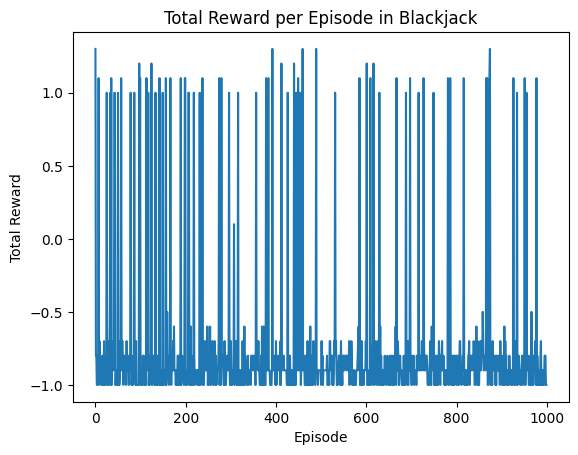

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Blackjack environment
class Blackjack:
    def __init__(self):
        self.reset()

    def reset(self):
        self.player_sum = np.random.randint(4, 12) + np.random.randint(1, 11)
        self.dealer_sum = np.random.randint(4, 12) + np.random.randint(1, 11)
        self.done = False
        return np.array([self.player_sum], dtype=np.float32)

    def step(self, action):
        if action == 0:  # Hit
            self.player_sum += np.random.randint(1, 11)
            if self.player_sum > 21:  # Bust
                self.done = True
                return np.array([self.player_sum], dtype=np.float32), -1, self.done
            else:
                # Intermediate reward for moving closer to 21
                return np.array([self.player_sum], dtype=np.float32), 0.1 if self.player_sum <= 21 else -0.1, self.done
        elif action == 1:  # Stick
            while self.dealer_sum < 17:
                self.dealer_sum += np.random.randint(1, 11)
            self.done = True
            if self.dealer_sum > 21 or self.player_sum > self.dealer_sum:
                return np.array([self.player_sum], dtype=np.float32), 1, self.done
            elif self.player_sum == self.dealer_sum:
                return np.array([self.player_sum], dtype=np.float32), 0, self.done
            else:
                return np.array([self.player_sum], dtype=np.float32), -1, self.done
        return np.array([self.player_sum], dtype=np.float32), 0, self.done

# Xavier Initialization for neural networks to avoid gradient issues
def xavier_initialization(input_dim, output_dim):
    bound = np.sqrt(6.0 / (input_dim + output_dim))
    return np.random.uniform(-bound, bound, (input_dim, output_dim))

# Policy Network
class PolicyNetwork:
    def __init__(self, state_dim, action_dim, hidden_units=128, lr=0.01):
        self.W1 = xavier_initialization(state_dim, hidden_units)  # Xavier initialization
        self.b1 = np.zeros(hidden_units)
        self.W2 = xavier_initialization(hidden_units, action_dim)  # Xavier initialization
        self.b2 = np.zeros(action_dim)
        self.lr = lr

    def forward(self, state):
        self.z1 = np.dot(state, self.W1) + self.b1
        self.a1 = np.maximum(0, self.z1)  # ReLU activation
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = np.exp(self.z2 - np.max(self.z2))  # Softmax Stability
        self.probs = self.a2 / np.sum(self.a2)
        return self.probs  # 1D probabilities array

    def backward(self, state, action, advantage):
        grad_z2 = self.probs.copy()
        grad_z2[action] -= 1
        grad_z2 *= advantage  # Scale by advantage

        # Gradients for W2 and b2
        grad_W2 = np.outer(self.a1, grad_z2)
        grad_b2 = grad_z2

        grad_a1 = np.dot(grad_z2, self.W2.T)
        grad_z1 = grad_a1 * (self.z1 > 0)  # ReLU derivative

        grad_W1 = np.outer(state, grad_z1)
        grad_b1 = grad_z1

        # Gradient clipping to control exploding gradients
        grad_W2 = self.clip_gradients(grad_W2)
        grad_b2 = self.clip_gradients(grad_b2)
        grad_W1 = self.clip_gradients(grad_W1)
        grad_b1 = self.clip_gradients(grad_b1)

        # Update weights and biases
        self.W2 -= self.lr * grad_W2
        self.b2 -= self.lr * grad_b2
        self.W1 -= self.lr * grad_W1
        self.b1 -= self.lr * grad_b1

    def clip_gradients(self, grad, max_norm=1.0):
        norm = np.linalg.norm(grad)
        if norm > max_norm:
            return grad * (max_norm / norm)
        return grad

# Helper function to select action (epsilon-greedy)
def choose_action(state, policy_net, epsilon=0.1):
    if np.random.rand() < epsilon:  # Exploration (random action)
        return np.random.choice(2), 0
    else:  # Exploitation (select action from policy)
        action_probs = policy_net.forward(state)
        action = np.random.choice(len(action_probs), p=action_probs)
        return action, action_probs[action]

# Compute discounted returns
def compute_returns(rewards, gamma):
    returns = []
    G = 0
    for reward in reversed(rewards):
        G = reward + gamma * G
        returns.insert(0, G)
    returns = np.array(returns, dtype=np.float32)
    return (returns - returns.mean()) / (returns.std() + 1e-8)  # Normalize

# Training loop
if __name__ == "__main__":
    env = Blackjack()

    state_dim = 1  # Player's sum is a single value
    action_dim = 2  # Two actions: Hit or Stick

    policy_net = PolicyNetwork(state_dim, action_dim, lr=0.001)  # Lower learning rate
    n_episodes = 1000
    gamma = 0.99
    epsilon = 0.1  # Epsilon-greedy parameter
    total_rewards_per_episode = []

    for episode in range(n_episodes):
        state = env.reset()
        episode_states = []
        episode_actions = []
        episode_rewards = []

        total_reward = 0
        done = False
        while not done:
            state_input = state.flatten()
            action, action_prob = choose_action(state_input, policy_net, epsilon)
            next_state, reward, done = env.step(action)

            episode_states.append(state_input)  # Save flat state
            episode_actions.append(action)
            episode_rewards.append(reward)

            total_reward += reward
            state = next_state

        total_rewards_per_episode.append(total_reward)

        # Compute returns (discounted)
        returns = compute_returns(episode_rewards, gamma)

        # Update policy using returns
        for state, action, G in zip(episode_states, episode_actions, returns):
            policy_net.backward(state, action, G)

        # Monitor progress
        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(total_rewards_per_episode[-50:])
            print(f'Episode {episode + 1}/{n_episodes}, Average Reward (last 50 episodes): {avg_reward:.2f}')

    # Plotting total rewards per episode
    plt.plot(total_rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode in Blackjack')
    plt.show()
